In [ ]:
"""
I am working with the Ford Motor Company Bill of Lading dataset from

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Part A: Computing Sikgt for Ford Motor Company**

Ford Motor Company-10-19-2024: 01-01-2015 to 30-09-2021
Ford Motor Company-10-19-2024 (1): 30-09-2021 to 30-09-2024


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#step 1 is to merge the two datasets

In [4]:
file_path = '/content/drive/My Drive/DISS DATA/Ford Motor Company-10-19-2024.xlsx'
df1 = pd.read_excel(file_path)
file_path = '/content/drive/My Drive/DISS DATA/Ford Motor Company-10-19-2024 (1).xlsx'
df2 = pd.read_excel(file_path)

In [5]:
# Concatenate both datasets
df = pd.concat([df1, df2], ignore_index=True)

In [6]:
#print(df_merged.head())

In [7]:
# Step 2: Convert "Arrival Date" to a proper datetime
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], errors='coerce')

# Drop any rows without a valid date
df = df.dropna(subset=['Arrival Date'])

print(df['Arrival Date'].dtypes)

datetime64[ns]


In [8]:
print(df['Company Name'].unique())

['Ford Motor Company' 'Ford Motor Company S A'
 'Ford Motor Company Brasil Ltda' 'Ford Motor Company C/O Fapco Inc'
 'Ford Motor Company Sa Exel Inc' 'Ford Motor Company Sa De Cv'
 'Ford Motor Company C/O Exel Inc' 'Ford Motor Company Thailand Limited'
 'Ford Motor Company Inc' 'Ford Motor Company Sa C / O Exel Inc'
 'Ford Motor Company Torin Inc'
 'Gz7Wd Ford Motor Company Hearn Industrial Services Inc'
 'Ford Motor Company 1500 Enterprise'
 'Ford Camacari Brasil Ford Motor Company'
 'Ford Motor Company C/O C/O Exel Inc'
 'Ford Motor Company Sa C/O Exel Inc'
 'Ford Camacari Pto Plant Gl0Aa Ford Motor Company'
 'Ford Motor Company Canada Ltd' 'Ford Motor Company Sa'
 'Ford Motor Company Etxqc /' 'Ap05A Ford Motor Company'
 'Artiflex G438A On Behalf Of Ford Motor Company'
 'Ford Motor Company On Behalf Of Pak Rite Industries Inc'
 'Artiflex Ae2Da On Behalf Of Ford Motor Company'
 'Ford Motor Company C/O Pak Rite Industries Inc'
 'Ford Motor Company C O Exel Inc' 'Ford Motor Company C/O'

In [9]:
#This includes subsidiaries, third party suppliers (that are integrated)

In [10]:
# ========== 3. DEFINE QUARTER COLUMN ==========
df['Quarter'] = df['Arrival Date'].dt.to_period('Q')

In [11]:
# ========== 3. SUM TOTAL VOLUME PER (QUARTER, HS CODE) ==========
# We'll call the columns "Quantity" or "Volume" depending on your dataset.
# Modify if you use "Weight" or something else.

group_total = (df
   .groupby(['Quarter', 'HS Code'], as_index=False)
   .agg(TotalVolume=('Quantity', 'sum'),FullDescription=('HS Code Full Description', 'first'))
)

In [12]:
print(group_total.head(500000))

     Quarter   HS Code  TotalVolume  \
0     2015Q1   30613.0         26.0   
1     2015Q1   40390.0        222.0   
2     2015Q1   40510.0         30.0   
3     2015Q1   40590.0         56.0   
4     2015Q1   91091.0         20.0   
...      ...       ...          ...   
4732  2024Q3  930610.0        762.0   
4733  2024Q3  940190.0         19.0   
4734  2024Q3  940350.0         54.0   
4735  2024Q3  960321.0          3.0   
4736  2024Q3  981800.0        400.0   

                                        FullDescription  
0     Fish and crustaceans, molluscs and other aquat...  
1     Dairy produce; birds eggs; natural honey; edib...  
2     Dairy produce; birds eggs; natural honey; edib...  
3     Dairy produce; birds eggs; natural honey; edib...  
4     Coffee, tea, maté and spices ; Ginger, saffron...  
...                                                 ...  
4732  Arms and ammunition; parts and accessories the...  
4733  Furniture; bedding, mattresses, mattress suppo...  
4734  Fur

The code below is just used for visualisation -  what products were shipped in each quarter

In [13]:
# Filter for rows where the Quarter is '2015Q1'
filtered_df = group_total[group_total['Quarter'] == '2018Q1']

# Group by HS Code and sum the Quantity column
hs_code_quantity = filtered_df.groupby('HS Code')['TotalVolume'].sum()

# Display the result
print(hs_code_quantity)

HS Code
80810.0       29.0
170240.0    1224.0
170490.0     201.0
200811.0      96.0
290341.0      11.0
             ...  
920999.0       1.0
940350.0    2623.0
950320.0       7.0
950629.0     527.0
981800.0     217.0
Name: TotalVolume, Length: 71, dtype: float64


In [14]:
# ========== 4. SUPPLIER-LEVEL VOLUME PER (QUARTER, HS CODE, SUPPLIER) ==========
group_supplier = (df
   .groupby(['Quarter', 'HS Code', 'Supplier Name'], as_index=False)
   .agg(SupplierVolume=('Quantity', 'sum'))
)


In [15]:
print(group_supplier.head(2000))

     Quarter   HS Code                         Supplier Name  SupplierVolume
0     2015Q1   30613.0           Zf Sistemas De Direcao Ltda            26.0
1     2015Q1   40390.0               Ford Otomotiv Sanayi As           202.0
2     2015Q1   40390.0                  Mahle Metal Leve S/A            20.0
3     2015Q1   40510.0   Faurecia Valencia Modulos De Puerta            30.0
4     2015Q1   40590.0            Faurecia Modulos De Puerta            42.0
...      ...       ...                                   ...             ...
1995  2017Q1  700910.0                    Fico Mirrors R1Amc           192.0
1996  2017Q1  720221.0                Ford Motor Company S A           288.0
1997  2017Q1  720229.0  Robert Bosch Direcao Automotiva Ltda            55.0
1998  2017Q1  731822.0    Zhejiang Wanfeng Auto Wheel Co Ltd            75.0
1999  2017Q1  820730.0              Rayhoo Motor Dies Co Ltd             2.0

[2000 rows x 4 columns]


In [16]:
# ========== 5. MERGE & COMPUTE s_{k}^g(t) ==========
merged = pd.merge(
    group_supplier,         # has SupplierVolume
    group_total,            # has TotalVolume
    on=['Quarter','HS Code'],
    how='left'
)

In [17]:
# s_{k}^g(t) = SupplierVolume / TotalVolume
merged['s_k^g(t)'] = merged['SupplierVolume'] / merged['TotalVolume']

In [18]:
print(merged[['Quarter', 'HS Code', 'Supplier Name', 's_k^g(t)']])
 #this is per product sikg(t) - treating all Ford Motor subitiaries as i

     Quarter   HS Code                                      Supplier Name  \
0     2015Q1   30613.0                        Zf Sistemas De Direcao Ltda   
1     2015Q1   40390.0                            Ford Otomotiv Sanayi As   
2     2015Q1   40390.0                               Mahle Metal Leve S/A   
3     2015Q1   40510.0                Faurecia Valencia Modulos De Puerta   
4     2015Q1   40590.0                         Faurecia Modulos De Puerta   
...      ...       ...                                                ...   
8097  2024Q3  940190.0                      Vibracoustic Thailand Limited   
8098  2024Q3  940350.0                    Guru Nanak Auto Enterprises Ltd   
8099  2024Q3  960321.0                     Summit Plastics Nanjing Co Ltd   
8100  2024Q3  981800.0  Eberspaecher Automotive Technology Tianjin Branch   
8101  2024Q3  981800.0                               Ford Otomotiv Sanayi   

      s_k^g(t)  
0      1.00000  
1      0.90991  
2      0.09009  
3      

## **Part B: Creating wgg' for all products (927 different products imported marked by HS code) **

Note: In your analysis mention that the amount of unique products per importer are around 900-1000 which is a good indication of the product variation required in the business and we can infer on the power of the local supply chain of a company given the variability of it's internaitonal imports. i.e if a firm imports more externally it could be that it ischeaper (which carries a tarrif cost OR that it's local supply chain and production capabilities are more resilient and cover more stuff)

In [19]:
###########################
# 1) LOAD AND PREP DATA   #
###########################

# Assume your DataFrame is `df` with columns:
#   'HS Code' and 'HS code Full Description'
# First, get a unique list of (HS Code, Description).
df_codes = df[['HS Code','HS Code Full Description']].drop_duplicates(subset=['HS Code'])

# Build a dictionary: {HS_code: description_text}.
desc_dict = dict(zip(df_codes['HS Code'], df_codes['HS Code Full Description']))

In [20]:
print(len(desc_dict)) #this means there are 917 unique products imported by tesla HS code wise. Note all HS code descriptions correspond to the HS code and are not product specific

927


In [21]:
import torch
from transformers import AutoTokenizer, AutoModel

In [22]:
#1. Setting up the model. I am using BERT for now
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # We only need inference

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # outputs.last_hidden_state shape: [batch_size, seq_length, hidden_dim]
    # We take the [CLS] token at index 0 to represent the entire text
    cls_vec = outputs.last_hidden_state[:, 0, :]
    return cls_vec.squeeze(0)  # shape: [hidden_dim]


In [24]:
#this computes dot product and divides by L2 to get the cosine similarity e{-1,1} aka how similary two unique descriptions of hs codes are
def cosine_sim(vec1, vec2):
    dot_val = torch.dot(vec1, vec2)
    norm_val = vec1.norm(p=2) * vec2.norm(p=2)
    return (dot_val / norm_val).item()


In [25]:
hs_codes = list(desc_dict.keys())  # e.g. [370220.0, 590610.0, 853649.0, ...]
n = len(hs_codes)

# Precompute embeddings for each unique HS Code
embeddings = {}
for code in hs_codes:
    text = str(desc_dict[code])  # in case of NaNs
    embeddings[code] = get_bert_embedding(text)

# Create an n x n array for pairwise similarities
W = np.zeros((n, n), dtype=float)

for i in range(n):
    for j in range(n):
        if i == j:
            W[i,j] = 1.0
        else:
            v1 = embeddings[hs_codes[i]]
            v2 = embeddings[hs_codes[j]]
            W[i,j] = cosine_sim(v1, v2)

In [26]:
print(W[:10, :10])
#non-normalized

[[1.         0.83649766 0.85491168 0.87306327 0.87846416 0.65860254
  0.83453453 0.82953382 0.84685212 0.83801097]
 [0.83649766 1.         0.89166892 0.82594973 0.90862566 0.71947479
  0.84291905 0.84587973 0.82385874 0.80263549]
 [0.85491168 0.89166892 1.         0.83485895 0.86867934 0.65971696
  0.94590276 0.85127968 0.82158816 0.81156766]
 [0.87306327 0.82594973 0.83485895 1.         0.84910071 0.62566495
  0.79994154 0.77900451 0.81141698 0.84142089]
 [0.87846416 0.90862566 0.86867934 0.84910071 1.         0.70133257
  0.86198109 0.85807818 0.88940811 0.88956833]
 [0.65860254 0.71947479 0.65971696 0.62566495 0.70133257 1.
  0.6219973  0.7466771  0.66139305 0.64685541]
 [0.83453453 0.84291905 0.94590276 0.79994154 0.86198109 0.6219973
  1.         0.87836647 0.81866258 0.79517031]
 [0.82953382 0.84587973 0.85127968 0.77900451 0.85807818 0.7466771
  0.87836647 1.         0.82722354 0.80999303]
 [0.84685212 0.82385874 0.82158816 0.81141698 0.88940811 0.66139305
  0.81866258 0.8272235

In [27]:
#normalization {0,1}
W_min, W_max = W.min(), W.max()
W_norm = (W - W_min)/(W_max - W_min)
#This is mix max normalization which is not good since the rows do not sum up to 1 as ALberto wanted

In [28]:
# 3. Convert back to a DataFrame, if desired
similarity_df_row_norm = pd.DataFrame(
    W_norm,
    index=hs_codes,     # same row labels
    columns=hs_codes    # same column labels
)

# Quick check that each row sums to ~1
print(similarity_df_row_norm.sum(axis=1))

730799.0    743.198063
870323.0    740.513430
841520.0    755.481159
441600.0    704.437513
870829.0    747.555771
               ...    
211960.0    570.639939
212160.0    570.639939
611593.0    698.151722
212300.0    570.639939
212230.0    570.639939
Length: 927, dtype: float64


In [29]:
print(similarity_df_row_norm.head(927))

          730799.0  870323.0  841520.0  441600.0  870829.0  50900.0   \
730799.0  1.000000  0.809655  0.831092  0.852224  0.858511  0.602555   
870323.0  0.809655  1.000000  0.873884  0.797376  0.893625  0.673421   
841520.0  0.831092  0.873884  1.000000  0.807748  0.847120  0.603853   
441600.0  0.852224  0.797376  0.807748  1.000000  0.824327  0.564210   
870829.0  0.858511  0.893625  0.847120  0.824327  1.000000  0.652300   
...            ...       ...       ...       ...       ...       ...   
211960.0  0.647866  0.683259  0.655439  0.650780  0.620919  0.540770   
212160.0  0.647866  0.683259  0.655439  0.650780  0.620919  0.540770   
611593.0  0.807766  0.800791  0.799224  0.726496  0.748031  0.583415   
212300.0  0.647866  0.683259  0.655439  0.650780  0.620919  0.540770   
212230.0  0.647866  0.683259  0.655439  0.650780  0.620919  0.540770   

          841590.0  847790.0  950590.0  830249.0  ...  852540.0  520100.0  \
730799.0  0.807370  0.801548  0.821710  0.811417  ...  0.8

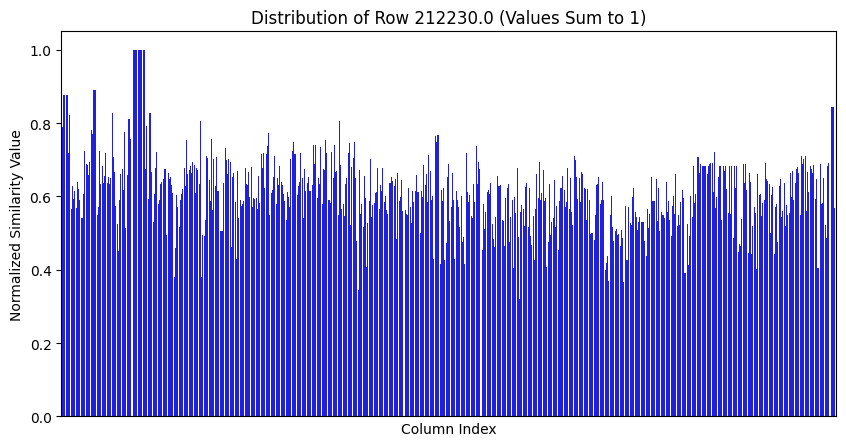

In [30]:
#Visualise the distribution of similarity of all products with each other
import matplotlib.pyplot as plt
import seaborn as sns

# Select a specific row (change index if needed)
row_index = 212230.0  # Example index from your dataset
row_values = similarity_df_row_norm.loc[row_index]

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=row_values.index, y=row_values.values, color="blue")

# Labels and title
plt.xlabel("Column Index")
plt.ylabel("Normalized Similarity Value")
plt.title(f"Distribution of Row {row_index} (Values Sum to 1)")
plt.xticks([])  # Remove x-ticks for readability

# Show plot
plt.show()

In [31]:
# 1) This function is applied row by row - aka you get the Sum of each row which is wgg' for each product
#    "row" is a Series of length N, each element is w_{g, g'} for a single g but all columns g'.
#    row.name is the row label, i.e. the HS code of g itself.
#    We do row.drop(row.name) so we exclude w_{g,g} (the self-similarity on the diagonal).
#    Then we take the mean of the rest.
df_mean_sim = similarity_df_row_norm.apply(
    lambda row: row.drop(row.name).mean(),
    axis=1
)

# df_mean_sim is now a Series with index=HS code, and
# the value is the average similarity to all other codes.
print(df_mean_sim.head(10))

730799.0    0.801510
870323.0    0.798611
841520.0    0.814774
441600.0    0.759652
870829.0    0.806216
50900.0     0.597286
841590.0    0.803845
847790.0    0.785903
950590.0    0.776946
830249.0    0.751130
dtype: float64


In [32]:
#I am storing this in a new dataframe --> I have the aggregated similarity of each product with all other products | it's HS code. this is wgg' where g' is {geG|g=\G}
df_avg_similarity = pd.DataFrame({
    'HS Code': df_mean_sim.index,
    'MeanSimilarity': df_mean_sim.values
})
df_avg_similarity.reset_index(drop=True, inplace=True)
print(df_avg_similarity.head(917))


      HS Code  MeanSimilarity
0    730799.0        0.801510
1    870323.0        0.798611
2    841520.0        0.814774
3    441600.0        0.759652
4    870829.0        0.806216
..        ...             ...
912  848590.0        0.806524
913  293229.0        0.733749
914  842122.0        0.773914
915  210420.0        0.750409
916   18500.0        0.559927

[917 rows x 2 columns]


# **Part C: Computing Xikgt --> Xit which you will merge with dataset and produce a time series dataset**

In [33]:
# 1) Merge on 'HS Code' to attach each product g's mean similarity
df_x = pd.merge(
    merged,                  # has s_k^g(t), Quarter, Supplier Name, ...
    df_avg_similarity,       # has 'HS Code' + 'MeanSimilarity'
    on='HS Code',            # matching column
    how='left'               # or 'inner' if you only want matching codes
)

print(df_x.head(10))

  Quarter   HS Code                           Supplier Name  SupplierVolume  \
0  2015Q1   30613.0             Zf Sistemas De Direcao Ltda            26.0   
1  2015Q1   40390.0                 Ford Otomotiv Sanayi As           202.0   
2  2015Q1   40390.0                    Mahle Metal Leve S/A            20.0   
3  2015Q1   40510.0     Faurecia Valencia Modulos De Puerta            30.0   
4  2015Q1   40590.0              Faurecia Modulos De Puerta            42.0   
5  2015Q1   40590.0     Faurecia Valencia Modulos De Puerta            14.0   
6  2015Q1   91091.0  Pgi Far East Precision Products Co Ltd            20.0   
7  2015Q1  120220.0       Yanfeng Visteon Automotive Co Ltd            71.0   
8  2015Q1  120924.0                Ford Otomotiv Sanayi A S            38.0   
9  2015Q1  170111.0             Zf Sistemas De Direcao Ltda            60.0   

   TotalVolume                                    FullDescription  s_k^g(t)  \
0         26.0  Fish and crustaceans, molluscs and 

In [34]:
print(df_x.shape)

(8102, 8)


In [35]:
# 2) Multiply to get x_{ik}^g(t)
df_x['x_ik^g(t)'] = df_x['s_k^g(t)'] * df_x['MeanSimilarity']

# 3) Display the results
print(
    df_x[
      ['Quarter', 'HS Code', 'Supplier Name', 's_k^g(t)', 'MeanSimilarity', 'x_ik^g(t)']
    ].head(30000)
)


     Quarter   HS Code                                      Supplier Name  \
0     2015Q1   30613.0                        Zf Sistemas De Direcao Ltda   
1     2015Q1   40390.0                            Ford Otomotiv Sanayi As   
2     2015Q1   40390.0                               Mahle Metal Leve S/A   
3     2015Q1   40510.0                Faurecia Valencia Modulos De Puerta   
4     2015Q1   40590.0                         Faurecia Modulos De Puerta   
...      ...       ...                                                ...   
8097  2024Q3  940190.0                      Vibracoustic Thailand Limited   
8098  2024Q3  940350.0                    Guru Nanak Auto Enterprises Ltd   
8099  2024Q3  960321.0                     Summit Plastics Nanjing Co Ltd   
8100  2024Q3  981800.0  Eberspaecher Automotive Technology Tianjin Branch   
8101  2024Q3  981800.0                               Ford Otomotiv Sanayi   

      s_k^g(t)  MeanSimilarity  x_ik^g(t)  
0      1.00000        0.690528 

**Aggregate across products for each supplier to get Xik(t)**

In [36]:
# 1) Group by quarter & supplier, then average x_{ik}^g(t) across products
df_x_agg = (
    df_x
    .groupby(['Quarter', 'Supplier Name'], as_index=False)
    .agg(Aggregated_x_ik=('x_ik^g(t)', 'mean'))  # or 'sum' if you prefer summation
)

# 2) Inspect the result
print(df_x_agg.head(15))

   Quarter                             Supplier Name  Aggregated_x_ik
0   2015Q1             Allevard Molas Do Brasil Ltda         0.424465
1   2015Q1                           Casting Ros S A         0.254233
2   2015Q1              Changan Ford Automobile Corp         0.009861
3   2015Q1        Changan Ford Mazda Automobile Corp         0.019722
4   2015Q1                  Chinafair Cargo Services         0.620699
5   2015Q1       Chinafair Cargo Services Internatio         0.388746
6   2015Q1               Chongqing Ante Trade Co Ltd         0.810864
7   2015Q1                     Citic Dicastal Co Ltd         0.805038
8   2015Q1                  Complex Cold Forming Ltd         0.599704
9   2015Q1        Continental Automotive Romania Srl         0.521947
10  2015Q1            Continental Automotive Systems         0.227460
11  2015Q1             Continental Teves Ag & Co Ohg         0.462396
12  2015Q1  Contitech Fluid Automotive Romania S R L         0.088010
13  2015Q1          

**Quick Graph Visualization**

In [37]:
import networkx as nx
import ipywidgets as widgets
from IPython.display import display

# 1) Filter by the quarter, then rename columns
quarter_of_interest = "2020Q3"
df_plot = df_x_agg[df_x_agg['Quarter'] == quarter_of_interest].copy()

print("Before rename, columns are:", df_plot.columns.tolist())
# Suppose we see "Supplier Name" and "Aggregated_x_ik" in that list.

df_plot.rename(
    columns={
        'Supplier Name': 'Supplier_Name',
        'Aggregated_x_ik': 'Aggregated_x_ik'
    },
    inplace=True
)
print("After rename, columns are:", df_plot.columns.tolist())

# 2) Use .itertuples() with named attributes
#    Now we can do row.Supplier_Name, row.Aggregated_x_ik, etc.
G = nx.Graph()
G.add_node("Tesla", bipartite=0)

for row in df_plot.itertuples(index=False):
    supplier = row.Supplier_Name  # now a valid attribute
    x_ik = row.Aggregated_x_ik

    G.add_node(supplier, bipartite=1)
    G.add_edge("Tesla", supplier, weight=x_ik)

# 3) Layout: Tesla on x=0, suppliers on x=2
pos = dict()
pos["Tesla"] = (0, 0)
for i, sup in enumerate(df_plot['Supplier_Name'].unique()):
    pos[sup] = (2, i*1.0)

df_temp = df_x_agg.copy()

# Rename columns to simpler names so they work well with .itertuples()
df_temp.rename(
    columns={
        "Supplier Name": "Supplier_Name",
        "Aggregated_x_ik": "Aggregated_x_ik"
    },
    inplace=True
)

# Let's see the unique quarters
unique_quarters = sorted(df_temp['Quarter'].unique())
print("Available quarters:", unique_quarters)



Before rename, columns are: ['Quarter', 'Supplier Name', 'Aggregated_x_ik']
After rename, columns are: ['Quarter', 'Supplier_Name', 'Aggregated_x_ik']
Available quarters: [Period('2015Q1', 'Q-DEC'), Period('2015Q2', 'Q-DEC'), Period('2015Q3', 'Q-DEC'), Period('2015Q4', 'Q-DEC'), Period('2016Q1', 'Q-DEC'), Period('2016Q2', 'Q-DEC'), Period('2016Q3', 'Q-DEC'), Period('2016Q4', 'Q-DEC'), Period('2017Q1', 'Q-DEC'), Period('2017Q2', 'Q-DEC'), Period('2017Q3', 'Q-DEC'), Period('2017Q4', 'Q-DEC'), Period('2018Q1', 'Q-DEC'), Period('2018Q2', 'Q-DEC'), Period('2018Q3', 'Q-DEC'), Period('2018Q4', 'Q-DEC'), Period('2019Q1', 'Q-DEC'), Period('2019Q2', 'Q-DEC'), Period('2019Q3', 'Q-DEC'), Period('2019Q4', 'Q-DEC'), Period('2020Q1', 'Q-DEC'), Period('2020Q2', 'Q-DEC'), Period('2020Q3', 'Q-DEC'), Period('2020Q4', 'Q-DEC'), Period('2021Q1', 'Q-DEC'), Period('2021Q2', 'Q-DEC'), Period('2021Q3', 'Q-DEC'), Period('2021Q4', 'Q-DEC'), Period('2022Q1', 'Q-DEC'), Period('2022Q2', 'Q-DEC'), Period('2022Q3', '

In [38]:
def plot_quarter_network(quarter_of_interest):
    """
    Given a quarter (string like '2015Q1'),
    build a bipartite (Tesla, Suppliers) network
    with edges weighted by Aggregated_x_ik.
    """
    # 1) Filter to the chosen quarter
    df_plot = df_temp[df_temp['Quarter'] == quarter_of_interest].copy()

    # 2) Create a graph; add Tesla as the single "buyer" node
    G = nx.Graph()
    G.add_node("Tesla", bipartite=0)

    # 3) Add edges from Tesla -> each supplier with 'weight' = x_ik
    for row in df_plot.itertuples(index=False):
        supplier = row.Supplier_Name
        x_ik = row.Aggregated_x_ik
        G.add_node(supplier, bipartite=1)
        G.add_edge("Tesla", supplier, weight=x_ik)

    # 4) Simple bipartite layout: Tesla on left, suppliers on right
    pos = {}
    pos["Tesla"] = (0, 0)
    for i, sup in enumerate(df_plot['Supplier_Name'].unique()):
        pos[sup] = (2, i * 1.0)  # x=2, different y

    # 5) Draw the network
    plt.figure(figsize=(8,6))
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos)

    # 6) Edge labels for the x_ik weight
    edge_labels = {(u,v): f"{data['weight']:.3f}" for u,v,data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Supplier–Ford Motors Company network for {quarter_of_interest}")
    plt.axis("off")
    plt.show()


In [39]:
# Create a dropdown widget to pick the quarter
quarter_dropdown = widgets.Dropdown(
    options=unique_quarters,
    description='Quarter:',
    value=unique_quarters[0]  # default selection
)

# Use `interact` to tie the function to the widget
widgets.interact(plot_quarter_network, quarter_of_interest=quarter_dropdown)

interactive(children=(Dropdown(description='Quarter:', options=(Period('2015Q1', 'Q-DEC'), Period('2015Q2', 'Q…

<function __main__.plot_quarter_network(quarter_of_interest)>

## **Part D: Get Xit and RUn regressions**

In [40]:
###############################################
# A) AGGREGATE X_ik(t) INTO X(t) PER QUARTER #
###############################################

# Suppose your DataFrame "df_x_agg" has columns:
#  ['Quarter', 'Supplier Name', 'Aggregated_x_ik']
#  from the step where you group by (Quarter, Supplier)
#  and average x_{ik}^g(t) across products.

# 1) For each Quarter, average across all suppliers:
df_quarter_x = (
    df_x_agg
    .groupby('Quarter', as_index=False)
    .agg(Xit=('Aggregated_x_ik', 'mean'))  # call it "X" for x(t)
)

print(df_quarter_x.head(40))

   Quarter       Xit
0   2015Q1  0.420235
1   2015Q2  0.331019
2   2015Q3  0.364465
3   2015Q4  0.358387
4   2016Q1  0.399273
5   2016Q2  0.377414
6   2016Q3  0.460752
7   2016Q4  0.448988
8   2017Q1  0.439749
9   2017Q2  0.450154
10  2017Q3  0.540642
11  2017Q4  0.540463
12  2018Q1  0.587294
13  2018Q2  0.498881
14  2018Q3  0.448769
15  2018Q4  0.520208
16  2019Q1  0.412696
17  2019Q2  0.467995
18  2019Q3  0.473701
19  2019Q4  0.562837
20  2020Q1  0.550273
21  2020Q2  0.560981
22  2020Q3  0.376966
23  2020Q4  0.327599
24  2021Q1  0.356880
25  2021Q2  0.345963
26  2021Q3  0.328268
27  2021Q4  0.373936
28  2022Q1  0.330913
29  2022Q2  0.391217
30  2022Q3  0.449069
31  2022Q4  0.461526
32  2023Q1  0.498525
33  2023Q2  0.479424
34  2023Q3  0.420759
35  2023Q4  0.455574
36  2024Q1  0.388001
37  2024Q2  0.374248
38  2024Q3  0.372911


In [44]:
# Export to Excel
df_quarter_x.to_excel("quarterly_data2.xlsx", index=False)

print("Excel file saved as 'quarterly_data.xlsx'.")

Excel file saved as 'quarterly_data.xlsx'.
